In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# ODEs
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp

# Networks
import networkx as nx
import EoN
from collections import defaultdict 

%matplotlib notebook

In [63]:
# total_tweets is I (Infected)

# Read first 400 timestamps
df = pd.read_csv('../data/timeseries/Verified/TRUMP_CHANTING_VERIFIED.csv')
df = df[:400]

yData = np.cumsum(df['total_tweets'])
xData = np.arange(0, len(df), 1)

# Time span for the solve_ivp function
tSpan = [0, len(df)]

# Initial infections at the start
I0 = yData[0]

------------ Estimated Parameters -------------
N = 46857
S0 = 37150.692663165544
S0 = 37150.692663165544
E0 = 292.27087638642195
Z0 = 9411.687395341216
beta = 0.004908866579884922
b = 0.034504198043902735
ro = 9.584023169106512
p = 0.5663266546955743
e = 0.015255406402432711
l = 0.2906591366480026


<IPython.core.display.Javascript object>


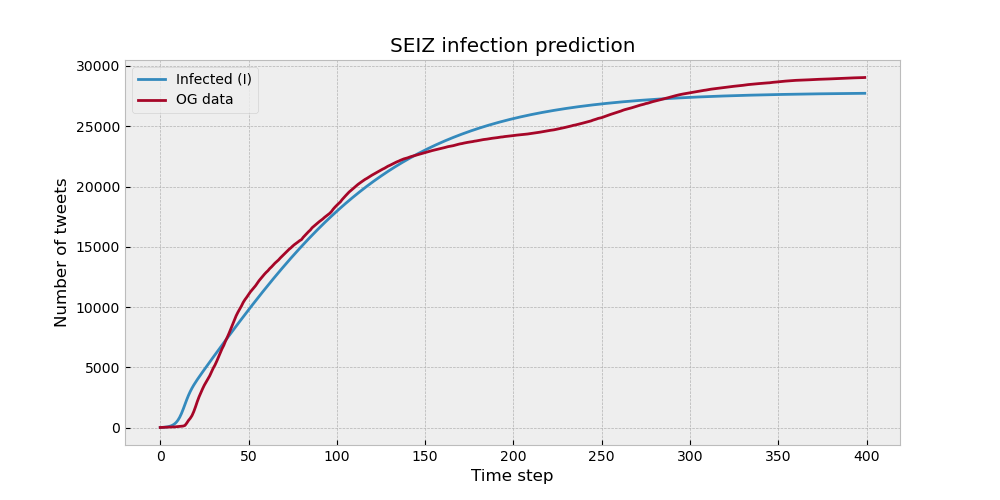

<IPython.core.display.Javascript object>


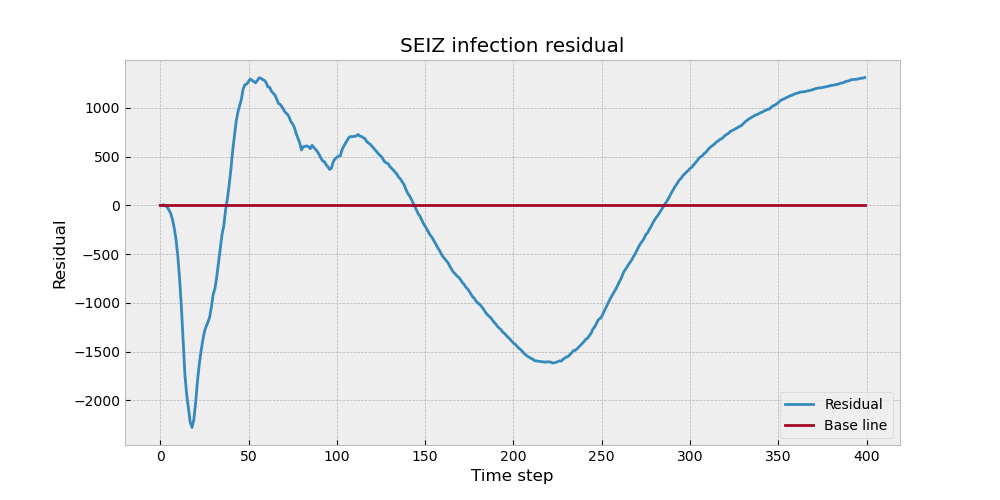

<IPython.core.display.Javascript object>


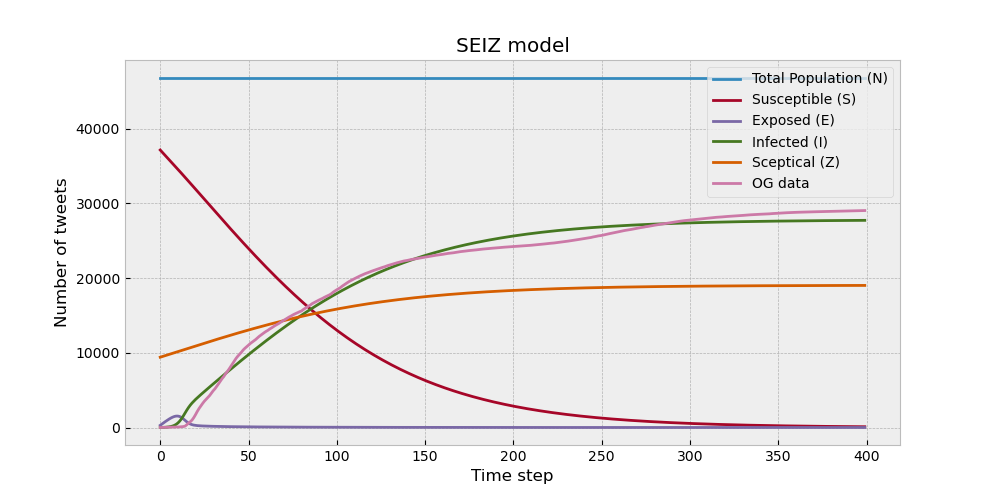

In [64]:
# Run this for the SEIZ model

# Function for SEIZ system of ODEs
# S0, E0, Z0, beta, b, ro, p, e and l are unknown
def seiz(t, y, S0, E0, Z0, beta, b, ro, p, e, l):
    S = y[0]
    E = y[1]
    I = y[2]
    Z = y[3]
    
    N = S0 + E0 + I0 + Z0
    
    dS = -1 * beta * S * (I / N) - b * S * (Z / N)
    dE = (1 - p) * beta * S * (I / N) + (1 - l) * b * S * (Z / N) - ro * E * (I / N) - e * E
    dI = p * beta * S * (I / N) + ro * E * (I / N) + e * E
    dZ = l * b * S * (Z / N)

    return [dS, dE, dI, dZ]

def solve_seiz(x, *args):
    initialValues = [args[0], args[1], I0, args[2]] # [S0, E0, I0, Z0]
    
    return solve_ivp(seiz, tSpan, initialValues, method='BDF', t_eval=x, args=args).y

def fit_seiz(x, *args):
    # Return the solution for the infections which we can then compare to the OG data
    return solve_seiz(x, *args)[2]

initial_guess = [100, 100, 100, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10]
bounds = (0, [9e8, 9e8, 9e8, 100, 100, 100, 1, 1, 1]) # All changing parameters should theoretically be between [0, 1]

popt, pcov = curve_fit(fit_seiz, xData, yData, initial_guess, bounds=bounds)

# Total population
N = round(popt[0] + popt[1] + I0 + popt[2])

print('------------ Estimated Parameters -------------')
print(f'N = {N}')
print(f'S0 = {popt[0]}')
print(f'S0 = {popt[0]}')
print(f'E0 = {popt[1]}')
print(f'Z0 = {popt[2]}')
print(f'beta = {popt[3]}')
print(f'b = {popt[4]}')
print(f'ro = {popt[5]}')
print(f'p = {popt[6]}')
print(f'e = {popt[7]}')
print(f'l = {popt[8]}')

# Fitted SEIZ model with the guessed args
fitted = solve_seiz(xData, *popt)

infected_residuals = yData - fitted[2]

# Plotting

# Prediction accuracy
plt.figure(figsize=(10, 5))
plt.title('SEIZ infection prediction')

plt.plot(fitted[2], label='Infected (I)')
plt.plot(yData, label='OG data')

plt.xlabel('Time step')
plt.ylabel('Number of tweets')

plt.legend()

plt.savefig('../images/seiz_odes_infection.png')

plt.show()

# Infection residual
plt.figure(figsize=(10, 5))
plt.title('SEIZ infection residual')

plt.plot(infected_residuals, label='Residual')
plt.plot([0] * len(df), label='Base line')

plt.xlabel('Time step')
plt.ylabel('Residual')

plt.legend()

plt.savefig('../images/seiz_residual.png')

plt.show()

# Whole SEIZ model
plt.figure(figsize=(10, 5))
plt.title('SEIZ model')

plt.plot([N] * len(df), label='Total Population (N)')
plt.plot(fitted[0], label='Susceptible (S)')
plt.plot(fitted[1], label='Exposed (E)')
plt.plot(fitted[2], label='Infected (I)')
plt.plot(fitted[3], label='Sceptical (Z)')

plt.plot(yData, label='OG data')

plt.xlabel('Time step')
plt.ylabel('Number of tweets')

plt.legend()

plt.savefig('../images/seiz_odes_full.png')

plt.show()

S0 = round(popt[0])
E0 = round(popt[1])
I0 = round(I0)
Z0 = round(popt[2])

beta = popt[3]
b = popt[4]
ro = popt[5]
p = popt[6]
e = popt[7]
l = popt[8]

## Network

In [4]:
# Power law follower distribution
degrees = []

in_degrees = []
out_degrees = []

for i in range(N):
    n = np.random.uniform(1, 330*1e6) # Random number (rank of a twitter user)
    
    follower_count = 1e7*((1 / n)**0.62)
    
    # We have to scale the "follower_count" based proportionally to the population size N
#     power_law_scaler = follower_count / 1e7
    
#     scaled_follower_count = (N - 1) * power_law_scaler
    
    degrees.append(round(follower_count))

# We sample the in/out degress from the same array
# This is because for the network the sums of in and out degress have to match
in_degrees = random.sample(degrees, len(degrees))
out_degrees = random.sample(degrees, len(degrees))

print(np.array(degrees).max())

34936


In [21]:
# Scale contact rate parameters for the network

average_degree = (np.array(out_degrees).sum() / N)

# Calculates how much bigger the parameters in the ODEs are
# compared to a network with a specific average out-degree
scaler = (N - 1) / average_degree

# The parameters in the ODEs are proportionally larger because of (1 / N)
# Therefore, we divide by N to scale it back for the networks
beta_ntw = (beta * scaler) / N
b_ntw = (b * scaler) / N
ro_ntw = (ro * scaler) / N

print('------------ Scaled Contact Rate Parameters -------------')
print(f'beta = {beta_ntw}')
print(f'b = {b_ntw}')
print(f'ro = {ro_ntw}')

------------ Scaled Contact Rate Parameters -------------
beta = 0.4189614799036209
b = 2.9448610264938186
ro = 817.9763016605733


In [23]:
# Creating a directed network and removing self-loops 

G = nx.directed_configuration_model(in_degrees, out_degrees)
G.remove_edges_from(nx.selfloop_edges(G))

<IPython.core.display.Javascript object>


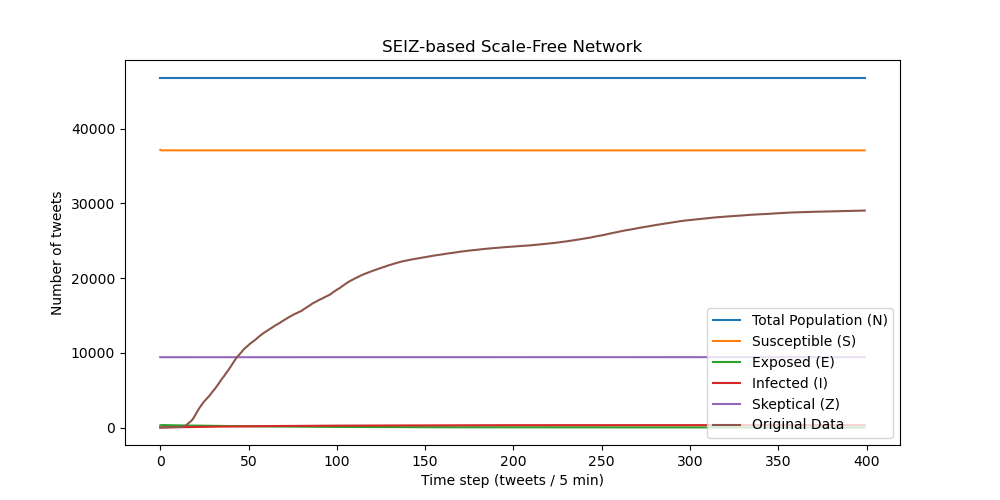

In [24]:
# EoN implementation

# Custom function which sums all rates based on the neighbour amount
# list_nbr is a list of different neighbours to look for (i.e. ['I', 'Z'])
# list_rates is a list of different rates of each list_nbr item
def return_combined_rates(G, node, status, list_nbr, list_rates):
    combined_rate = 0
    
    for i in range(len(list_nbr)):
        nbr_status = list_nbr[i]
        rate = list_rates[i]  
        
        neighbours = len([nbr for nbr in G.neighbors(node) if status[nbr] == nbr_status])
        
        combined_rate += (rate * neighbours)
    
    return combined_rate

# This function needs to return the rate at which node changes status.
def rate_function(G, node, status, parameters):
    beta_ntw, b_ntw, ro_ntw, p, e, l = parameters
    
    if status[node] == 'E':
        return e + return_combined_rates(G, node, status, ['I'], [ro_ntw])
    
    elif status[node] == 'S':
        return return_combined_rates(G, node, status, ['I', 'Z'], [beta_ntw, b_ntw])
    else:
        return 0

# This function needs to return the new status of the node
# This function already implies that the node is changing state
def transition_choice(G, node, status, parameters):
    beta_ntw, b_ntw, ro_ntw, p, e, l = parameters

    if status[node] == 'E':
        return 'I'
    elif status[node] == 'S':
        
        rate_of_infection = return_combined_rates(G, node, status, ['I'], [beta_ntw])
        rate_of_skeptisim = return_combined_rates(G, node, status, ['Z'], [b_ntw])
        
        combined_rate = rate_of_infection + rate_of_skeptisim

        prob_of_infection = rate_of_infection / combined_rate
        prob_of_skeptisim = rate_of_skeptisim / combined_rate
        
        # Depending on the rate of both infection and skeptisim, determine how should
        # the model behave based on probabilities
        if np.random.choice(['I', 'Z'], p=[prob_of_infection, prob_of_skeptisim]) == 'I':
            # If the infection rate is higher than skeptisim
            # that means that the model has a higher probability to become either I or E state
            return np.random.choice(['I', 'E'], p=[p, 1 - p])
        else:
            # If the skeptisim rate is higher than infection
            # that means that the model has a higher probability to become either E or Z state
            return np.random.choice(['E', 'Z'], p=[1 - l, l])


# This function needs to return any node whose rates might change
# because a node has just changed status through "transition_choice" function.
def get_influence_set(G, node, status, parameters):
    # "predecessors" captures all nodes who are following the node which could have become infected
    # Using neighbours here is incorrect!
    return G.predecessors(node)

parameters = (beta_ntw, b_ntw, ro_ntw, p, e, l)

IC = defaultdict(lambda: 'S')

# Setting initial values. Probably could be done in a smarter way :)
for node in range(E0):
    IC[node] = 'E'
    
for node in range(I0):
    IC[node + I0] = 'I'

for node in range(round(Z0)):
    IC[node + (E0 + I0)] = 'Z'


t, S, E, I, Z = EoN.Gillespie_complex_contagion(G, rate_function,
                           transition_choice, get_influence_set, IC,
                           return_statuses=('S', 'E', 'I', 'Z'),
                           parameters=parameters, tmax=400)

plt.figure(figsize=(10, 5))
plt.title('SEIZ-based Scale-Free Network')

plt.plot([N] * len(df), label='Total Population (N)')

plt.plot(t, S, label='Susceptible (S)')
plt.plot(t, E, label='Exposed (E)')
plt.plot(t, I, label='Infected (I)')
plt.plot(t, Z, label='Skeptical (Z)')

plt.plot(yData, label='Original Data')

plt.xlabel('Time step (tweets / 5 min)')
plt.ylabel('Number of tweets')

plt.legend()

plt.savefig('../images/seiz_network.png')

plt.show()

## Many Simulations - For now the code is a combination of above cells

In [73]:
# Run many simulations
# This will have a copy of the existing code

I_simulations = []
simulation_count = 50

for i in range(simulation_count):
    print(f'------ Initializing simulation {i + 1} out of {simulation_count} ------')
    
    # Power law follower distribution
    degrees = []

    in_degrees = []
    out_degrees = []

    for i in range(N):
        n = np.random.uniform(1, 330*1e6) # Random number (rank of a twitter user)

        follower_count = 1e7*((1 / n)**0.62)

        # We have to scale the "follower_count" based proportionally to the population size N
    #     power_law_scaler = follower_count / 1e7

    #     scaled_follower_count = (N - 1) * power_law_scaler

        degrees.append(round(follower_count))

    # We sample the in/out degress from the same array
    # This is because for the network the sums of in and out degress have to match
    in_degrees = random.sample(degrees, len(degrees))
    out_degrees = random.sample(degrees, len(degrees))
    
    # Scale contact rate parameters for the network

    average_degree = (np.array(out_degrees).sum() / N)

    # Calculates how much bigger the parameters in the ODEs are
    # compared to a network with a specific average out-degree
    scaler = (N - 1) / average_degree

    # The parameters in the ODEs are proportionally larger because of (1 / N)
    # Therefore, we divide by N to scale it back for the networks
    beta_ntw = (beta * scaler) / N
    b_ntw = (b * scaler) / N
    ro_ntw = (ro * scaler) / N

    print(f'beta = {beta_ntw}')
    print(f'b = {b_ntw}')
    print(f'ro = {ro_ntw}')
    
    G = nx.directed_configuration_model(in_degrees, out_degrees)
    G.remove_edges_from(nx.selfloop_edges(G))
    
    print('Network initalizied')
    
    # EoN implementation

    # Custom function which sums all rates based on the neighbour amount
    # list_nbr is a list of different neighbours to look for (i.e. ['I', 'Z'])
    # list_rates is a list of different rates of each list_nbr item
    def return_combined_rates(G, node, status, list_nbr, list_rates):
        combined_rate = 0

        for i in range(len(list_nbr)):
            nbr_status = list_nbr[i]
            rate = list_rates[i]  

            neighbours = len([nbr for nbr in G.neighbors(node) if status[nbr] == nbr_status])

            combined_rate += (rate * neighbours)

        return combined_rate

    # This function needs to return the rate at which node changes status.
    def rate_function(G, node, status, parameters):
        beta_ntw, b_ntw, ro_ntw, p, e, l = parameters

        if status[node] == 'E':
            return e + return_combined_rates(G, node, status, ['I'], [ro_ntw])

        elif status[node] == 'S':
            return return_combined_rates(G, node, status, ['I', 'Z'], [beta_ntw, b_ntw])
        else:
            return 0

    # This function needs to return the new status of the node
    # This function already implies that the node is changing state
    def transition_choice(G, node, status, parameters):
        beta_ntw, b_ntw, ro_ntw, p, e, l = parameters

        if status[node] == 'E':
            return 'I'
        elif status[node] == 'S':

            rate_of_infection = return_combined_rates(G, node, status, ['I'], [beta_ntw])
            rate_of_skeptisim = return_combined_rates(G, node, status, ['Z'], [b_ntw])

            combined_rate = rate_of_infection + rate_of_skeptisim

            prob_of_infection = rate_of_infection / combined_rate
            prob_of_skeptisim = rate_of_skeptisim / combined_rate

            # Depending on the rate of both infection and skeptisim, determine how should
            # the model behave based on probabilities
            if np.random.choice(['I', 'Z'], p=[prob_of_infection, prob_of_skeptisim]) == 'I':
                # If the infection rate is higher than skeptisim
                # that means that the model has a higher probability to become either I or E state
                return np.random.choice(['I', 'E'], p=[p, 1 - p])
            else:
                # If the skeptisim rate is higher than infection
                # that means that the model has a higher probability to become either E or Z state
                return np.random.choice(['E', 'Z'], p=[1 - l, l])


    # This function needs to return any node whose rates might change
    # because a node has just changed status through "transition_choice" function.
    def get_influence_set(G, node, status, parameters):
        # "predecessors" captures all nodes who are following the node which could have become infected
        # Using neighbours here is incorrect!
        return G.predecessors(node)

    parameters = (beta_ntw, b_ntw, ro_ntw, p, e, l)

    IC = defaultdict(lambda: 'S')

    # Setting initial values. Probably could be done in a smarter way :)
    for node in range(E0):
        IC[node] = 'E'

    for node in range(I0):
        IC[node + I0] = 'I'

    for node in range(round(Z0)):
        IC[node + (E0 + I0)] = 'Z'


    t, S, E, I, Z = EoN.Gillespie_complex_contagion(G, rate_function,
                               transition_choice, get_influence_set, IC,
                               return_statuses=('S', 'E', 'I', 'Z'),
                               parameters=parameters, tmax=400)
    
    I_simulations.append({
        't': t,
        'I': I
    })
    
    print('Network approximated')
    print('\n')

------ Initializing simulation 1 out of 50 ------
beta = 3.646393783308981e-05
b = 0.00025630334660327705
ro = 0.0711918361075898
Network initalizied
Network approximated


------ Initializing simulation 2 out of 50 ------
beta = 3.533622009698115e-05
b = 0.00024837667035915986
ro = 0.06899009101324033
Network initalizied
Network approximated


------ Initializing simulation 3 out of 50 ------
beta = 3.3754045170823065e-05
b = 0.00023725563536995147
ro = 0.06590106813940333
Network initalizied
Network approximated


------ Initializing simulation 4 out of 50 ------
beta = 3.598972873154282e-05
b = 0.0002529701525781948
ro = 0.07026599488899753
Network initalizied
Network approximated


------ Initializing simulation 5 out of 50 ------
beta = 3.596742561466682e-05
b = 0.00025281338499261006
ro = 0.07022245050142774
Network initalizied
Network approximated


------ Initializing simulation 6 out of 50 ------
beta = 3.483235036619164e-05
b = 0.0002448349931315223
ro = 0.06800634067178955
N

Network initalizied
Network approximated


------ Initializing simulation 49 out of 50 ------
beta = 3.6085773223351935e-05
b = 0.000253645244906022
ro = 0.07045351121680639
Network initalizied
Network approximated


------ Initializing simulation 50 out of 50 ------
beta = 3.669379644032582e-05
b = 0.00025791901221102983
ro = 0.0716406098074894
Network initalizied
Network approximated




<IPython.core.display.Javascript object>


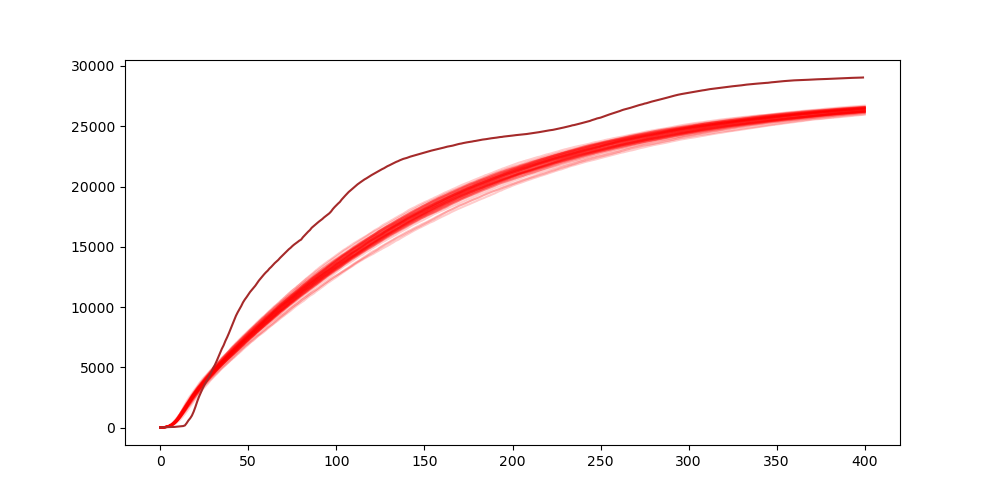

In [77]:
# Plot simulations

plt.figure(figsize=(10, 5))

plt.style.use('default')
    
for sim in I_simulations:
    t_sim = sim['t']
    I_sim = sim['I']
    
    plt.plot(t_sim, I_sim, color=(1, 0, 0, 0.2), linestyle='-', label='Infected (I)')
    
plt.plot(yData, 'brown', label='Original Data')

plt.show()

<IPython.core.display.Javascript object>


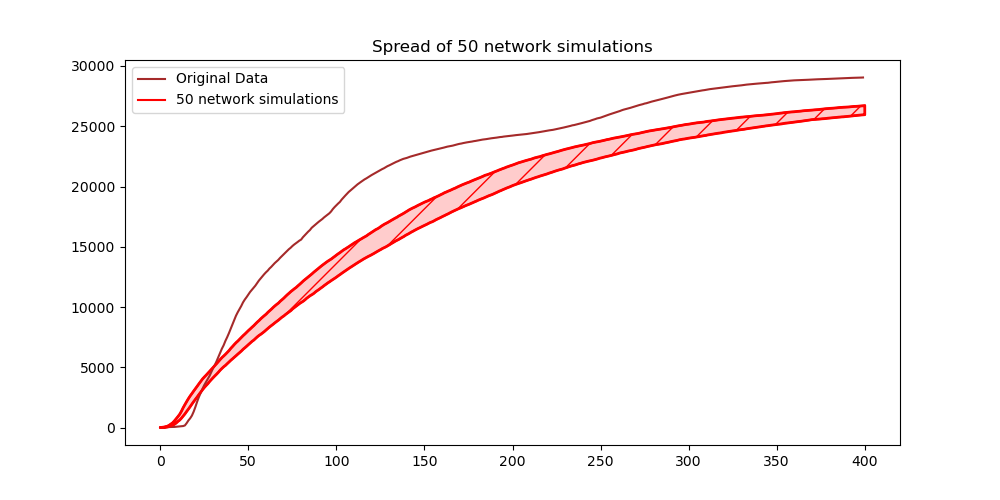

In [105]:
x_common = np.linspace(0,400,400)

plt.figure(figsize=(10, 5))

plt.title('Spread of 50 network simulations')

y = []

for sim in I_simulations:
    t_sim = sim['t']
    I_sim = sim['I']
    
    y_i = np.interp(x_common, t_sim, I_sim)
    
    y.append(y_i)     
             
y = np.stack(y)

ymax = np.max(y, axis=0)
ymin = np.min(y, axis=0)

plt.plot(yData, 'brown', label='Original Data')

plt.plot(x_common, ymax, 'red', label='50 network simulations')
plt.plot(x_common, ymin, 'red')

plt.fill_between(x_common, ymax, ymin, facecolor=(1, 0, 0, 0.2), hatch ='/', edgecolor='red', linewidth=2)

plt.legend()

plt.savefig('../images/50_network_spread.png')

plt.show()

In [87]:
ymax

array([2.00000000e+00, 1.58736601e+01, 3.60000000e+01, 6.40000000e+01,
       1.07090988e+02, 1.82000000e+02, 2.83000000e+02, 3.87950040e+02,
       5.44647018e+02, 7.20342557e+02, 9.04000000e+02, 1.09400000e+03,
       1.34900000e+03, 1.64558412e+03, 1.90740529e+03, 2.16050079e+03,
       2.40555719e+03, 2.62800000e+03, 2.82900000e+03, 3.03887185e+03,
       3.24000000e+03, 3.44001686e+03, 3.64776910e+03, 3.84250765e+03,
       4.03700000e+03, 4.19800000e+03, 4.34598742e+03, 4.50688859e+03,
       4.66500000e+03, 4.83100000e+03, 4.98908398e+03, 5.15363348e+03,
       5.31255997e+03, 5.48200000e+03, 5.65000000e+03, 5.81000000e+03,
       5.94120581e+03, 6.08433665e+03, 6.23660938e+03, 6.39005432e+03,
       6.57542462e+03, 6.73186906e+03, 6.89860053e+03, 7.04995364e+03,
       7.18200000e+03, 7.33300000e+03, 7.48300000e+03, 7.63100000e+03,
       7.76400000e+03, 7.90957355e+03, 8.05400000e+03, 8.18400000e+03,
       8.32600000e+03, 8.45700000e+03, 8.60882054e+03, 8.75422552e+03,
      

In [84]:
y

array([[2.00000000e+00, 1.50000000e+01, 3.30000000e+01, ...,
        2.64590000e+04, 2.64770000e+04, 2.64860000e+04],
       [2.00000000e+00, 1.20000000e+01, 2.50000000e+01, ...,
        2.62071971e+04, 2.62190000e+04, 2.62290000e+04],
       [2.00000000e+00, 8.00000000e+00, 1.20000000e+01, ...,
        2.59360000e+04, 2.59451967e+04, 2.59600000e+04],
       ...,
       [2.00000000e+00, 8.00000000e+00, 1.30000000e+01, ...,
        2.63952391e+04, 2.64045838e+04, 2.64120000e+04],
       [2.00000000e+00, 1.50000000e+01, 2.60000000e+01, ...,
        2.62541804e+04, 2.62700000e+04, 2.62800000e+04],
       [2.00000000e+00, 7.00000000e+00, 1.60000000e+01, ...,
        2.66080000e+04, 2.66270000e+04, 2.66360000e+04]])

In [41]:
y_common

array([0.])

In [45]:
x1[len(x1) - 1]

26396.0

In [48]:
I_simulations[0]['I'][len(I_simulations[0]['I']) - 1]

26396

In [51]:
x

array([[2.00000000e+00, 6.00000000e+00, 1.60000000e+01, 3.70000000e+01,
        6.10000000e+01, 1.00000000e+02, 1.81000000e+02, 2.89000000e+02,
        4.22000000e+02, 6.06000000e+02, 7.89000000e+02, 9.90167495e+02,
        1.21600000e+03, 1.45523941e+03, 1.67400000e+03, 1.90602040e+03,
        2.14864666e+03, 2.38200000e+03, 2.60852545e+03, 2.82737085e+03,
        3.02400000e+03, 3.21200000e+03, 3.42600000e+03, 3.61200000e+03,
        3.81000000e+03, 3.98153833e+03, 4.14800000e+03, 4.31500000e+03,
        4.46600000e+03, 4.61086411e+03, 4.77700000e+03, 4.93265518e+03,
        5.10139605e+03, 5.25600000e+03, 5.40838524e+03, 5.55700000e+03,
        5.74200000e+03, 5.88900000e+03, 6.03100000e+03, 6.16841790e+03,
        6.31700000e+03, 6.43583412e+03, 6.58542924e+03, 6.72200000e+03,
        6.86300000e+03, 7.00500000e+03, 7.16100000e+03, 7.29237991e+03,
        7.40491779e+03, 7.53120488e+03, 7.66149396e+03, 7.80500000e+03,
        7.93303963e+03, 8.04003798e+03, 8.16121804e+03, 8.304932

In [52]:
xmax

array([2.00000000e+00, 1.10000000e+01, 2.00000000e+01, 3.70000000e+01,
       6.43943020e+01, 1.00000000e+02, 1.81000000e+02, 2.89000000e+02,
       4.22000000e+02, 6.06000000e+02, 7.89000000e+02, 9.90167495e+02,
       1.21600000e+03, 1.45523941e+03, 1.70300000e+03, 1.94400000e+03,
       2.17201839e+03, 2.38611613e+03, 2.63056447e+03, 2.82737085e+03,
       3.02400000e+03, 3.22600000e+03, 3.42600000e+03, 3.61200000e+03,
       3.81000000e+03, 3.98153833e+03, 4.14800000e+03, 4.31500000e+03,
       4.46600000e+03, 4.61086411e+03, 4.77700000e+03, 4.93478772e+03,
       5.10139605e+03, 5.26300000e+03, 5.43400000e+03, 5.58700000e+03,
       5.74619706e+03, 5.89660584e+03, 6.06412908e+03, 6.21492297e+03,
       6.37074734e+03, 6.50047511e+03, 6.65507444e+03, 6.80200000e+03,
       6.94800000e+03, 7.08539804e+03, 7.22400000e+03, 7.37000000e+03,
       7.50293463e+03, 7.61900000e+03, 7.76447286e+03, 7.90400000e+03,
       8.04216205e+03, 8.19751426e+03, 8.33700000e+03, 8.49221409e+03,
      

In [53]:
xmin

array([2.00000000e+00, 6.00000000e+00, 1.60000000e+01, 3.60000000e+01,
       6.10000000e+01, 9.50000000e+01, 1.68419528e+02, 2.73000000e+02,
       3.94000000e+02, 5.28643900e+02, 7.00833415e+02, 8.85000000e+02,
       1.14600000e+03, 1.42100000e+03, 1.67400000e+03, 1.90602040e+03,
       2.14864666e+03, 2.38200000e+03, 2.60852545e+03, 2.82585387e+03,
       3.02119343e+03, 3.21200000e+03, 3.41300000e+03, 3.58690608e+03,
       3.75700000e+03, 3.94000000e+03, 4.11745755e+03, 4.28400000e+03,
       4.44485239e+03, 4.58600000e+03, 4.74200000e+03, 4.93265518e+03,
       5.09661986e+03, 5.25600000e+03, 5.40838524e+03, 5.55700000e+03,
       5.74200000e+03, 5.88900000e+03, 6.03100000e+03, 6.16841790e+03,
       6.31700000e+03, 6.43583412e+03, 6.58542924e+03, 6.72200000e+03,
       6.86300000e+03, 7.00500000e+03, 7.16100000e+03, 7.29237991e+03,
       7.40491779e+03, 7.53120488e+03, 7.66149396e+03, 7.80500000e+03,
       7.93303963e+03, 8.04003798e+03, 8.16121804e+03, 8.30493274e+03,
      